#  MODELLING AND PREDICTION

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from time import time
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import randint, uniform, loguniform
from IPython.display import display
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
import shap
from sklearn.inspection import PartialDependenceDisplay
import random
import os

In [2]:
RANDOM_STATE = 45

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)

In [3]:
final_dataset = pd.read_csv('C:\\Users\\Lenovo\\Desktop\\DATA SCIENCE\\PAPER\\education paper\\Data from IPEDS\\merged_dataset_for_imputation_and_ML.csv')

In [4]:
#Getting numerical and categorical features for column transfer for preprocessing,
#(missing value imputation and standardization)
cat_features = ['recs_required','test_scores_required']
num_features = list(set(final_dataset.drop(['grad_rate'],axis=1)) - set(cat_features))


target_col_grad = 'grad_rate'
feature_cols = num_features + cat_features

In [5]:
#Split the dataset by year (train dataset is 2012 to 2016 dataset. Test data is 2017 dataset)
train_df = final_dataset[final_dataset['year'] <= 2016].copy()
test_df = final_dataset[final_dataset['year'] == 2017].copy()

X_train_grad = train_df[feature_cols]
y_train_grad = train_df[target_col_grad]

X_test_grad = test_df[feature_cols]
y_test_grad = test_df[target_col_grad]

In [6]:
# 3. The preprocessing pipeline for linear regression, SVR which includes StandardScaler
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('scaler', StandardScaler())
                        ])

preprocessor_grad = ColumnTransformer([('num', num_pipeline, num_features),
                                       ('cat', 'passthrough', cat_features)
                                      ])

In [7]:
#The preprocessing pipeline for tree based models. Tree models can do without standardization with StandardScaler
num_pipeline_tree = Pipeline([('imputer', SimpleImputer(strategy='median'))
                             ])

preprocessor_tree_models = ColumnTransformer([('num', num_pipeline_tree, num_features),
                                              ('cat', 'passthrough', cat_features)
                                             ])

# Initial modelling

In [8]:
#Function to train and evaluate Linear and SVR models
def run_model_grad(model, model_name='Model'):
    pipe = Pipeline([('preprocessor', preprocessor_grad), #using linear reg, SVR preprocessor pipeline
                     ('regressor', model)
                    ])

    pipe.fit(X_train_grad, y_train_grad)
    y_train_pred = pipe.predict(X_train_grad)
    print('-' * 40)
    print(f"{model_name} Evaluation")
    print('-' * 40)
    print(f"Train R²: {r2_score(y_train_grad, y_train_pred):.4f}")
    print(f"Train RMSE: {root_mean_squared_error(y_train_grad, y_train_pred):.4f}")
    print(f"Train MAE: {mean_absolute_error(y_train_grad, y_train_pred):.4f}")
    print(' ')
    return pipe, y_train_pred 



#Function to train and evaluate tree models
def run_model_grad_tree(model, model_name='Model'):
    pipe = Pipeline([('preprocessor', preprocessor_tree_models), #using tree preprocessor pipeline
                     ('regressor', model)
                    ])

    pipe.fit(X_train_grad, y_train_grad)
    y_train_pred = pipe.predict(X_train_grad)
    print('-' * 40)
    print(f"{model_name} Evaluation")
    print('-' * 40)
    print(f"Train R²: {r2_score(y_train_grad, y_train_pred):.4f}")
    print(f"Train RMSE: {root_mean_squared_error(y_train_grad, y_train_pred):.4f}")
    print(f"Train MAE: {mean_absolute_error(y_train_grad, y_train_pred):.4f}")
    print(' ')
    return pipe, y_train_pred

In [9]:
#Fitting multiple models
models_grad = {'Linear Regression': LinearRegression(),
               'Decision Tree': DecisionTreeRegressor(random_state=RANDOM_STATE),
               'Random Forest': RandomForestRegressor(random_state=RANDOM_STATE),
               'XGBoost': XGBRegressor(random_state=RANDOM_STATE, verbosity=0),
               'SVR': SVR(),
               'LGBM' : LGBMRegressor(random_state=RANDOM_STATE)
              }


results_grad = {} #dictionary to save results
for name, model in models_grad.items():
    if name in ['Linear Regression', 'SVR']:   #if these models then use its relevant function preprocessor
        pipe, y_train_pred = run_model_grad(model, name)
        results_grad[name] = {'pipeline': pipe,
                              'train_pred':y_train_pred
                             }
    
    else:
        pipe, y_train_pred = run_model_grad_tree(model, name)
        results_grad[name] = {'pipeline': pipe,
                               'train_pred':y_train_pred
                             }

----------------------------------------
Linear Regression Evaluation
----------------------------------------
Train R²: 0.7833
Train RMSE: 9.8971
Train MAE: 7.0543
 
----------------------------------------
Decision Tree Evaluation
----------------------------------------
Train R²: 1.0000
Train RMSE: 0.0000
Train MAE: 0.0000
 
----------------------------------------
Random Forest Evaluation
----------------------------------------
Train R²: 0.9805
Train RMSE: 2.9719
Train MAE: 1.9783
 
----------------------------------------
XGBoost Evaluation
----------------------------------------
Train R²: 0.9898
Train RMSE: 2.1518
Train MAE: 1.6168
 
----------------------------------------
SVR Evaluation
----------------------------------------
Train R²: 0.7878
Train RMSE: 9.7932
Train MAE: 6.6295
 
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4635
[

### RANDOMIZED SEARCH CV with iteration = 20 and cv = 5

In [10]:
#functions to produce train and test results 

def evaluate_model_train(y_true_train, y_pred_train, best_params=None):
    print('-' * 40)
    print(f"Train R²: {r2_score(y_true_train, y_pred_train):.4f}")
    print(f"Train RMSE: {root_mean_squared_error(y_true_train, y_pred_train):.4f}")
    print(f"Train MAE: {mean_absolute_error(y_true_train, y_pred_train):.4f}")
    print(f"Best Params: {best_params}")
    
    
def evaluate_model_test(y_true_test, y_pred_test):
    print('')
    print('')
    print(f"Test R²: {r2_score(y_true_test, y_pred_test):.4f}")
    print(f"Test RMSE: {root_mean_squared_error(y_true_test, y_pred_test):.4f}")
    print(f"Test MAE: {mean_absolute_error(y_true_test, y_pred_test):.4f}")
    
    

In [11]:
#5-fold cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

n_iter = 20

#### Linear regression

In [12]:
#basic pipeline for linear regression
pipe_lr = Pipeline([('preprocessor', preprocessor_grad),
                    ('model', LinearRegression())])

print("Training Linear Regression...")
tic = time()

#fitting the model
pipe_lr.fit(X_train_grad, y_train_grad)
print(f"done in {time() - tic:.3f}s")


y_train_pred_lr = pipe_lr.predict(X_train_grad) #predict train input data for model evaluation
y_test_pred_lr = pipe_lr.predict(X_test_grad)  #predict test input data for model evaluation

#evaluate train
evaluate_model_train(y_train_grad, y_train_pred_lr)

#evaluate test
evaluate_model_test(y_test_grad, y_test_pred_lr)

Training Linear Regression...
done in 0.049s
----------------------------------------
Train R²: 0.7833
Train RMSE: 9.8971
Train MAE: 7.0543
Best Params: None


Test R²: 0.7104
Test RMSE: 10.9572
Test MAE: 7.6822


#### Decision Tree

In [13]:
#pipeline for decision tree
pipe_dt = Pipeline([('preprocessor', preprocessor_tree_models),
                    ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))])


#dictionary of hyperparameters
param_dist_dt = {
    'model__max_depth': [None, 5, 10, 20, 30],
    'model__min_samples_split': randint(2, 50),
    'model__min_samples_leaf': randint(1, 50),
    'model__max_features': ['sqrt', 'log2', None]
}


#applying randomized search for parameters
search_dt = RandomizedSearchCV(pipe_dt, 
                               param_distributions=param_dist_dt,
                               n_iter=n_iter, 
                               cv=cv, 
                               scoring='r2',
                               random_state=RANDOM_STATE,
                               n_jobs=-1)

print("Training Decision Tree...")
tic = time()

search_dt.fit(X_train_grad, y_train_grad)
print(f"done in {time() - tic:.3f}s")


best_dt = search_dt.best_estimator_
y_train_pred_dt = best_dt.predict(X_train_grad) #predict train input data for model evaluation
y_test_pred_dt = best_dt.predict(X_test_grad)  #predict test input data for model evaluation



#evaluate train
evaluate_model_train(y_train_grad, y_train_pred_dt, search_dt.best_params_)
print("Best R2 score from cross-validation:", search_dt.best_score_)

#evaluate test
evaluate_model_test(y_test_grad, y_test_pred_dt)

Training Decision Tree...
done in 13.108s
----------------------------------------
Train R²: 0.8497
Train RMSE: 8.2420
Train MAE: 5.8424
Best Params: {'model__max_depth': 10, 'model__max_features': None, 'model__min_samples_leaf': 17, 'model__min_samples_split': 26}
Best R2 score from cross-validation: 0.766398077386483


Test R²: 0.6906
Test RMSE: 11.3250
Test MAE: 7.9173


#### Random Forest

In [14]:
#pipeline for random forest
pipe_rf = Pipeline([('preprocessor', preprocessor_tree_models),
                    ('model', RandomForestRegressor(random_state=RANDOM_STATE))])

#dictionary of hyperparameters
param_dist_rf = {
    'model__n_estimators': randint(100, 300),
    'model__max_depth': [10, 30, None],
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5),
    'model__max_features': ['sqrt', None]
}


#applying randomized search for parameters
search_rf = RandomizedSearchCV(pipe_rf, 
                               param_distributions=param_dist_rf,
                               n_iter=n_iter, 
                               cv=cv, 
                               scoring='r2', 
                               random_state=RANDOM_STATE,
                              n_jobs=1)

print("Training Random Forest...")
tic = time()


search_rf.fit(X_train_grad, y_train_grad)
print(f"done in {time() - tic:.3f}s")

best_rf = search_rf.best_estimator_
y_train_pred_rf = best_rf.predict(X_train_grad)   #predict train input data for model evaluation
y_test_pred_rf = best_rf.predict(X_test_grad)    #predict test input data for model evaluation



#evaluate train
evaluate_model_train(y_train_grad, y_train_pred_rf, search_rf.best_params_)
print("Best R2 score from cross-validation:", search_rf.best_score_)

#evaluate test
evaluate_model_test(y_test_grad, y_test_pred_rf)

Training Random Forest...
done in 1234.711s
----------------------------------------
Train R²: 0.9794
Train RMSE: 3.0485
Train MAE: 2.0339
Best Params: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 3, 'model__n_estimators': 154}
Best R2 score from cross-validation: 0.8573383919200819


Test R²: 0.7997
Test RMSE: 9.1123
Test MAE: 6.0002


#### XGBoost

In [15]:
#pipeline for xgboost
pipe_xgb = Pipeline([('preprocessor', preprocessor_tree_models),
                     ('model', XGBRegressor(random_state=RANDOM_STATE, verbosity=0))])


#dictionary of hyperparameters
param_dist_xgb = {
    'model__n_estimators': randint(100, 300),
    'model__max_depth': [3, 5, 7, 10, None],
    'model__learning_rate': uniform(0.01, 0.3),  # ~0.01 to 0.31
    'model__subsample': uniform(0.5, 0.5),       # 0.5 to 1.0
    'model__colsample_bytree': uniform(0.5, 0.5),# 0.5 to 1.0
    #'model__gamma': uniform(0, 5)
}


#applying xgboost search for parameters
search_xgb = RandomizedSearchCV(pipe_xgb, 
                                param_distributions=param_dist_xgb,
                                n_iter=n_iter, 
                                cv=cv, 
                                scoring='r2', 
                                random_state=RANDOM_STATE,
                               n_jobs=1)


print("Training XGBoost...")
tic = time()
search_xgb.fit(X_train_grad, y_train_grad)
print(f"done in {time() - tic:.3f}s")

best_xgb = search_xgb.best_estimator_

y_train_pred_xg = best_xgb.predict(X_train_grad)   #predict train input data for model evaluation
y_test_pred_xg = best_xgb.predict(X_test_grad)    #predict test input data for model evaluation



#evaluate train
evaluate_model_train(y_train_grad, y_train_pred_xg, search_xgb.best_params_)
print("Best R2 score from cross-validation:", search_xgb.best_score_)

#evaluate test
evaluate_model_test(y_test_grad, y_test_pred_xg)

Training XGBoost...
done in 238.463s
----------------------------------------
Train R²: 0.9588
Train RMSE: 4.3133
Train MAE: 3.2273
Best Params: {'model__colsample_bytree': 0.7258332633232768, 'model__learning_rate': 0.03824167873014774, 'model__max_depth': None, 'model__n_estimators': 227, 'model__subsample': 0.8708770639803047}
Best R2 score from cross-validation: 0.8651763230299819


Test R²: 0.8024
Test RMSE: 9.0500
Test MAE: 5.8177


#### SVR


In [16]:
#pipeline for xgboost
pipe_svr = Pipeline([('preprocessor', preprocessor_grad),
                     ('model', SVR())])


#dictionary of hyperparameters
param_dist_svr = {
    'model__C': loguniform(1e-1, 1e2),        # 0.1 to 100
    'model__gamma': loguniform(1e-3, 1e-1),   # 0.001 to 0.1
    'model__epsilon': uniform(0.05, 0.3),     # 0.05 to 0.35
    #'model__kernel': ['rbf', 'poly']
}


#applying SVR search for parameters
search_svr = RandomizedSearchCV(pipe_svr, 
                                param_distributions=param_dist_svr,
                                n_iter=n_iter, 
                                cv=cv, 
                                scoring='r2', 
                                random_state=45,
                                n_jobs=-1)

print("Training SVR...")
tic = time()

search_svr.fit(X_train_grad, y_train_grad)
print(f"done in {time() - tic:.3f}s")

best_svr = search_svr.best_estimator_

y_train_pred_svr = best_svr.predict(X_train_grad)    #predict train input data for model evaluation
y_test_pred_svr = best_svr.predict(X_test_grad)     #predict test input data for model evaluation


#evaluate train
evaluate_model_train(y_train_grad, y_train_pred_svr, search_svr.best_params_)
print("Best R2 score from cross-validation:", search_svr.best_score_)


#evaluate test
evaluate_model_test(y_test_grad, y_test_pred_svr)

Training SVR...
done in 183.333s
----------------------------------------
Train R²: 0.9165
Train RMSE: 6.1420
Train MAE: 3.6270
Best Params: {'model__C': 93.79183965007391, 'model__epsilon': 0.19110522452113565, 'model__gamma': 0.01724205265883069}
Best R2 score from cross-validation: 0.8505380108985301


Test R²: 0.8112
Test RMSE: 8.8470
Test MAE: 5.7218


#### LGBM

In [17]:
#pipeline for xgboost
pipe_lgbm = Pipeline([('preprocessor', preprocessor_tree_models),
                 ('model', LGBMRegressor(random_state=RANDOM_STATE))])


#dictionary of hyperparameters
param_dist_lgbm = {
                    'model__n_estimators': randint(100, 300),
                    'model__learning_rate': uniform(0.01, 0.3),
                    #'model__max_depth': [3, 5, 7, 10],
                    'model__num_leaves': [20, 31, 50, 70],
                    #'model__min_data_in_leaf': [5, 20, 30]
            }


#applying SVR search for parameters
search_lgbm = RandomizedSearchCV(pipe_lgbm, 
                            param_dist_lgbm, 
                            cv=cv, 
                            n_iter=n_iter, 
                            scoring='r2',
                            random_state=RANDOM_STATE, 
                            n_jobs=-1)

print("Training LGBM...")
tic = time()
search_lgbm.fit(X_train_grad, y_train_grad)
print(f"done in {time() - tic:.3f}s")



best_lgbm = search_lgbm.best_estimator_

y_train_pred_lgbm = best_lgbm.predict(X_train_grad)   #predict train input data for model evaluation
y_test_pred_lgbm = best_lgbm.predict(X_test_grad)    #predict test input data for model evaluation


#evaluate train
evaluate_model_train(y_train_grad, y_train_pred_lgbm,  search_lgbm.best_params_)
print("Best R2 score from cross-validation:", search_lgbm.best_score_)


#evaluate test
evaluate_model_test(y_test_grad, y_test_pred_lgbm)

Training LGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4635
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 29
[LightGBM] [Info] Start training from score 42.704851
done in 56.057s
----------------------------------------
Train R²: 0.9882
Train RMSE: 2.3138
Train MAE: 1.6911
Best Params: {'model__learning_rate': 0.0948001619593502, 'model__n_estimators': 226, 'model__num_leaves': 50}
Best R2 score from cross-validation: 0.8643013163161324


Test R²: 0.7991
Test RMSE: 9.1262
Test MAE: 5.7313


# SHAP

In [18]:
#using all data points for SHAP for a more holistic analysis
X_data = final_dataset[feature_cols].copy()
y_data = final_dataset[target_col_grad].copy()

In [19]:
model_only_grad = best_xgb.named_steps.model    #using the best model for shap
preprocessor_fitted_grad = best_xgb.named_steps.preprocessor   


# Transform the data
X_transformed = preprocessor_fitted_grad.transform(X_data)


# Create DataFrame version for plotting
X_transformed_df = pd.DataFrame(X_transformed, columns=X_data.columns)

# SHAP explainer
explainer_grad = shap.Explainer(model_only_grad, X_transformed_df, seed=RANDOM_STATE)
shap_values = explainer_grad(X_transformed_df, check_additivity=False)

100%|===================| 8037/8052 [02:02<00:00]        

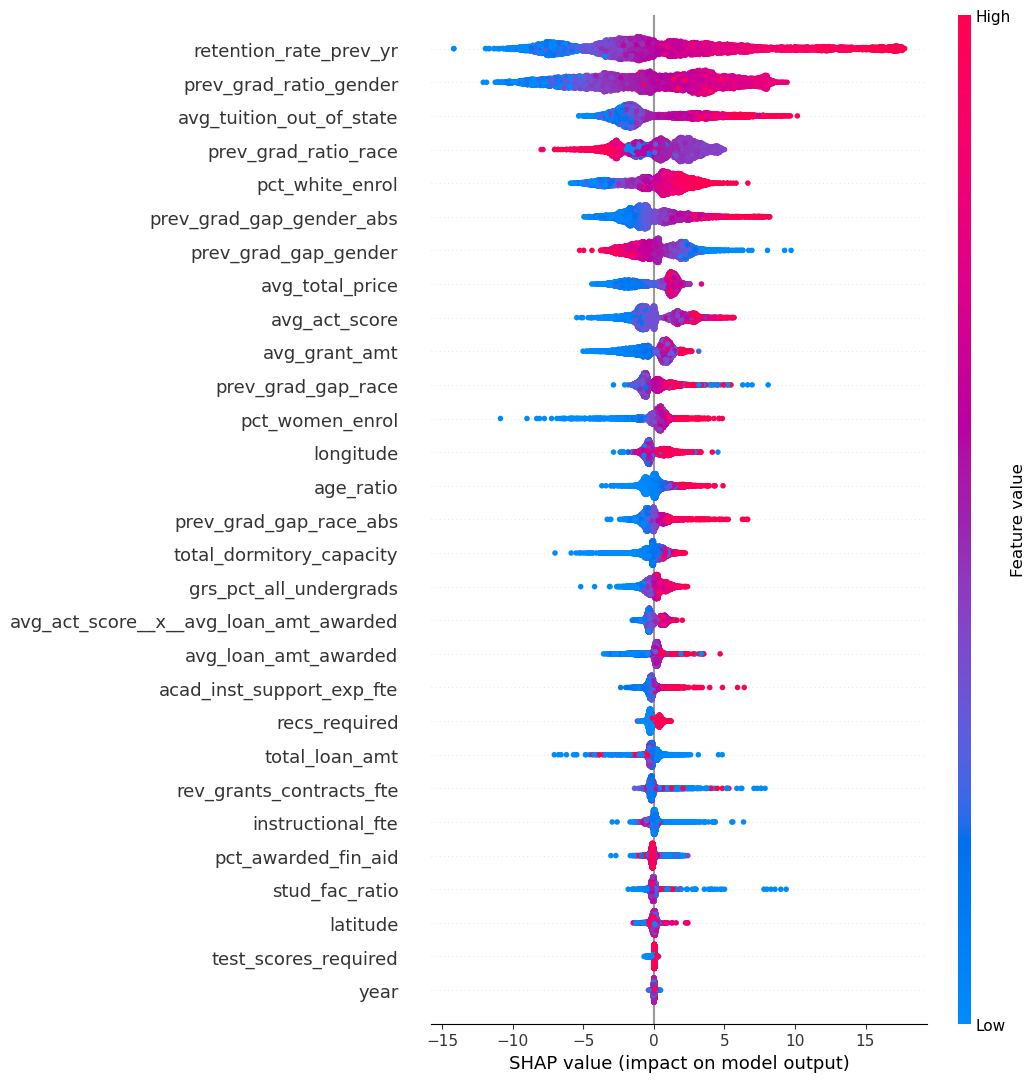

In [20]:
# SHAP summary plot
shap.plots.beeswarm(shap_values, max_display=40, show=False)

plt.savefig("C:\\Users\\Lenovo\\Desktop\\DATA SCIENCE\\PAPER\\education paper\\Plots\\shap_summary.png", 
            bbox_inches='tight', dpi=300)
plt.close()

shap.plots.beeswarm(shap_values, max_display=40)

#### Individual plots

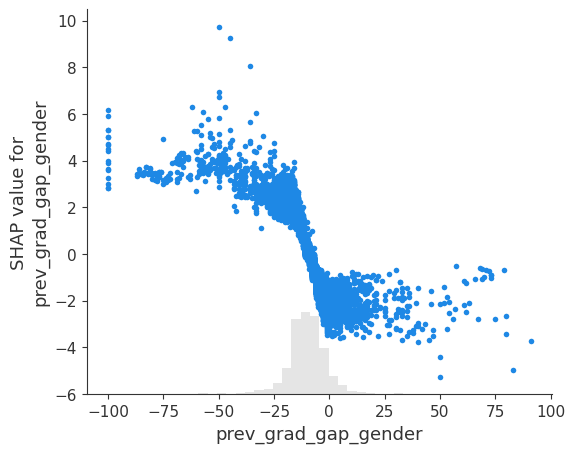

In [21]:
#SHAP Dependence Plot (Interaction & Nonlinearity)
shap.plots.scatter(shap_values[:, "prev_grad_gap_gender"])

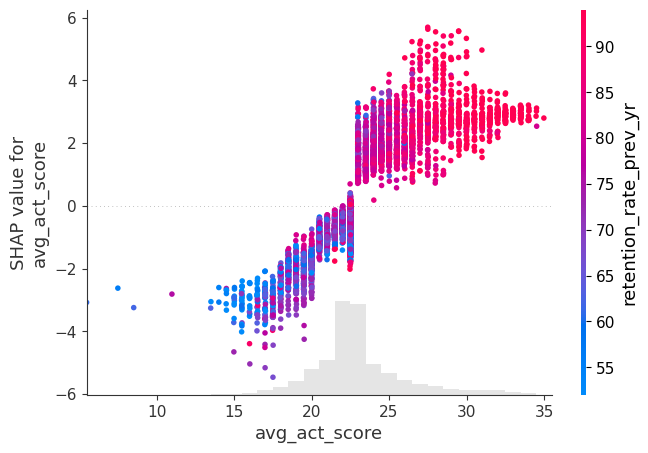

In [22]:
#SHAP Dependence Plot (Interaction & Nonlinearity)
shap.plots.scatter(shap_values[:, "avg_act_score"], 
                   color=shap_values[:,"retention_rate_prev_yr"])

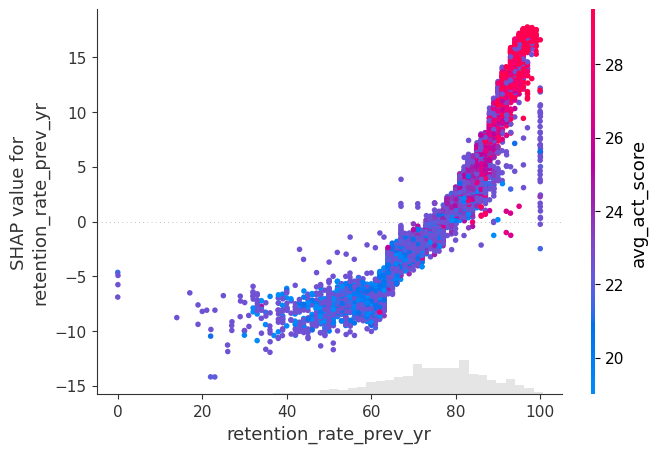

In [23]:
#SHAP Dependence Plot (Interaction & Nonlinearity)
shap.plots.scatter(shap_values[:, "retention_rate_prev_yr"], 
                   color=shap_values[:,"avg_act_score"])

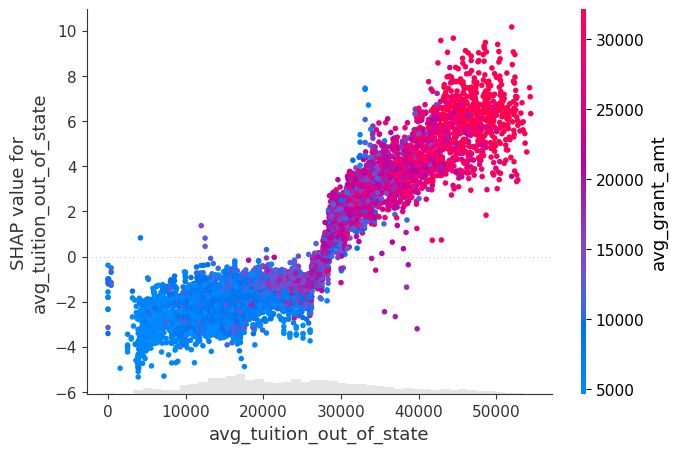

In [24]:
#SHAP Dependence Plot (Interaction & Nonlinearity)
shap.plots.scatter(shap_values[:, "avg_tuition_out_of_state"], 
                   color=shap_values[:,"avg_grant_amt"])

In [25]:
shap.initjs()

In [26]:
#SHAP Force Plot (Local Explanation for 1 School-Year)
# Pick one instance
schools_idx = [800, 70, 500, 75]
for x in schools_idx:
    print(f"school_idx: {x}")
    display(shap.force_plot(shap_values[x]))


school_idx: 800


school_idx: 70


school_idx: 500


school_idx: 75


school_idx: 75


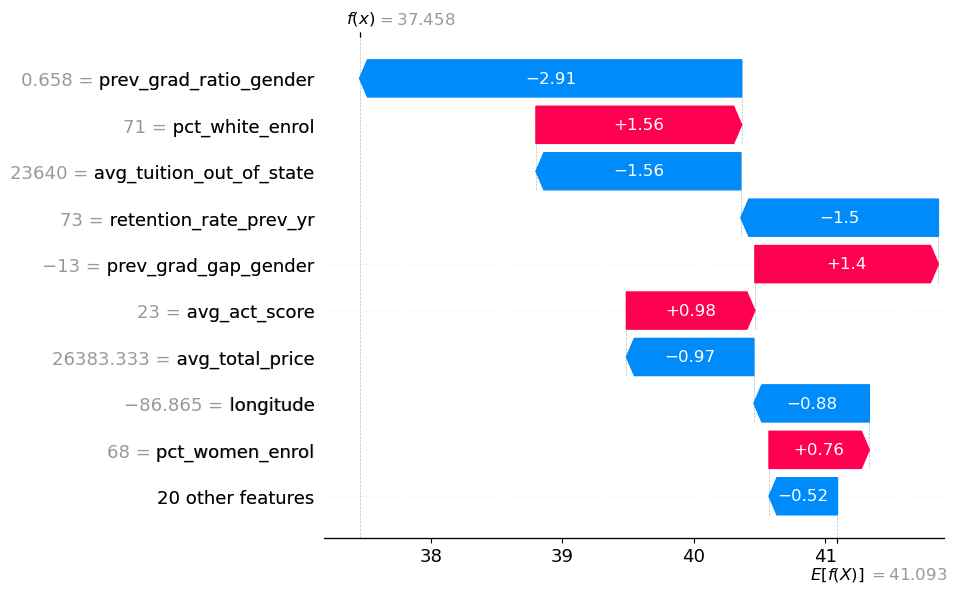

In [27]:
print(f"school_idx: 75")
shap.waterfall_plot(shap_values[75], show=False)

# Save current figure
plt.savefig("C:\\Users\\Lenovo\\Desktop\\DATA SCIENCE\\PAPER\\education paper\\Plots\\waterfall_75.png", 
            dpi=300, bbox_inches='tight')

# close the figure to avoid overlaps in loops
plt.close()

shap.waterfall_plot(shap_values[75])

school_idx: 70


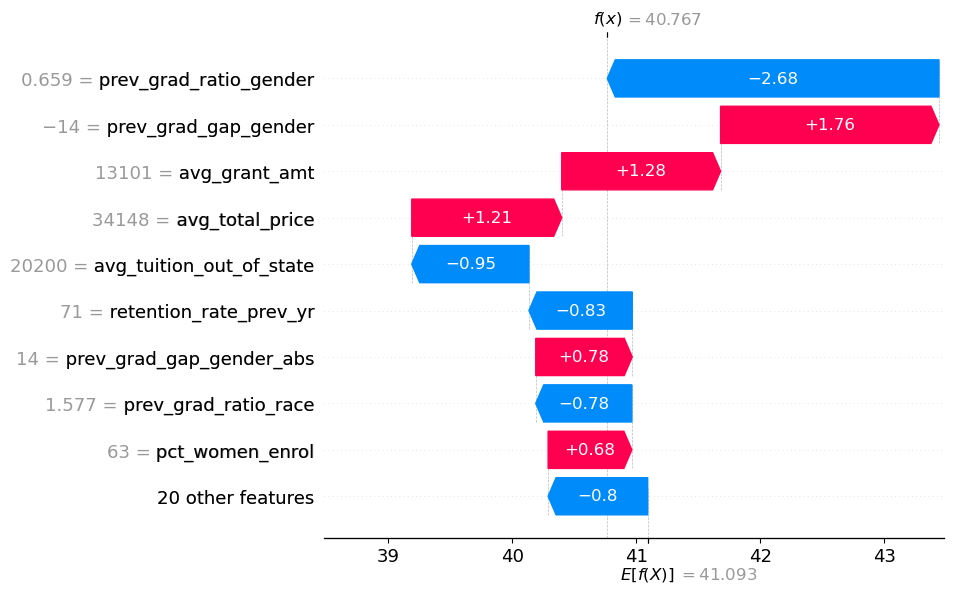

In [28]:
print(f"school_idx: 70")
shap.waterfall_plot(shap_values[70], show=False)

# Save current figure
plt.savefig("C:\\Users\\Lenovo\\Desktop\\DATA SCIENCE\\PAPER\\education paper\\Plots\\waterfall_70.png", 
            dpi=300, bbox_inches='tight')

# close the figure to avoid overlaps in loops
plt.close()

shap.waterfall_plot(shap_values[70])

# Partial Dependence Plots (PDP)
Shows the average effect of a feature on the model’s prediction.
Use PDPs for interpretable policy recommendations. Example: "Increasing ACT scores by 2 points improves graduation rates by X%"

In [29]:
X_pdp = preprocessor_fitted_grad.transform(X_data)
X_pdp_df = pd.DataFrame(X_pdp, columns=X_data.columns)

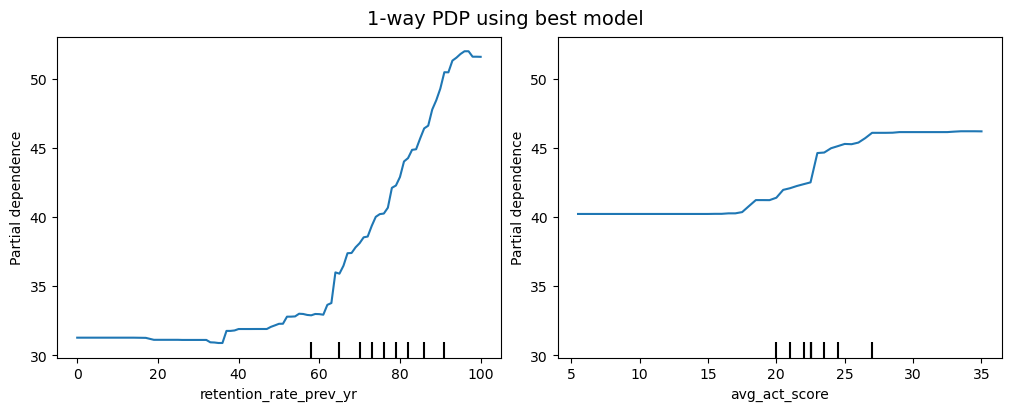

In [30]:

_, ax = plt.subplots(ncols=2, figsize=(10, 4), constrained_layout=True)

# Plot PDPs for key features
features_to_plot = ['retention_rate_prev_yr', 'avg_act_score']
display = PartialDependenceDisplay.from_estimator(best_xgb, 
                                        X_pdp_df, 
                                        features=features_to_plot, 
                                        kind='average', 
                                        ax=ax,
                                        random_state=RANDOM_STATE)

_ = display.figure_.suptitle("1-way PDP using best model", fontsize=14)

#plt.tight_layout()
plt.show()




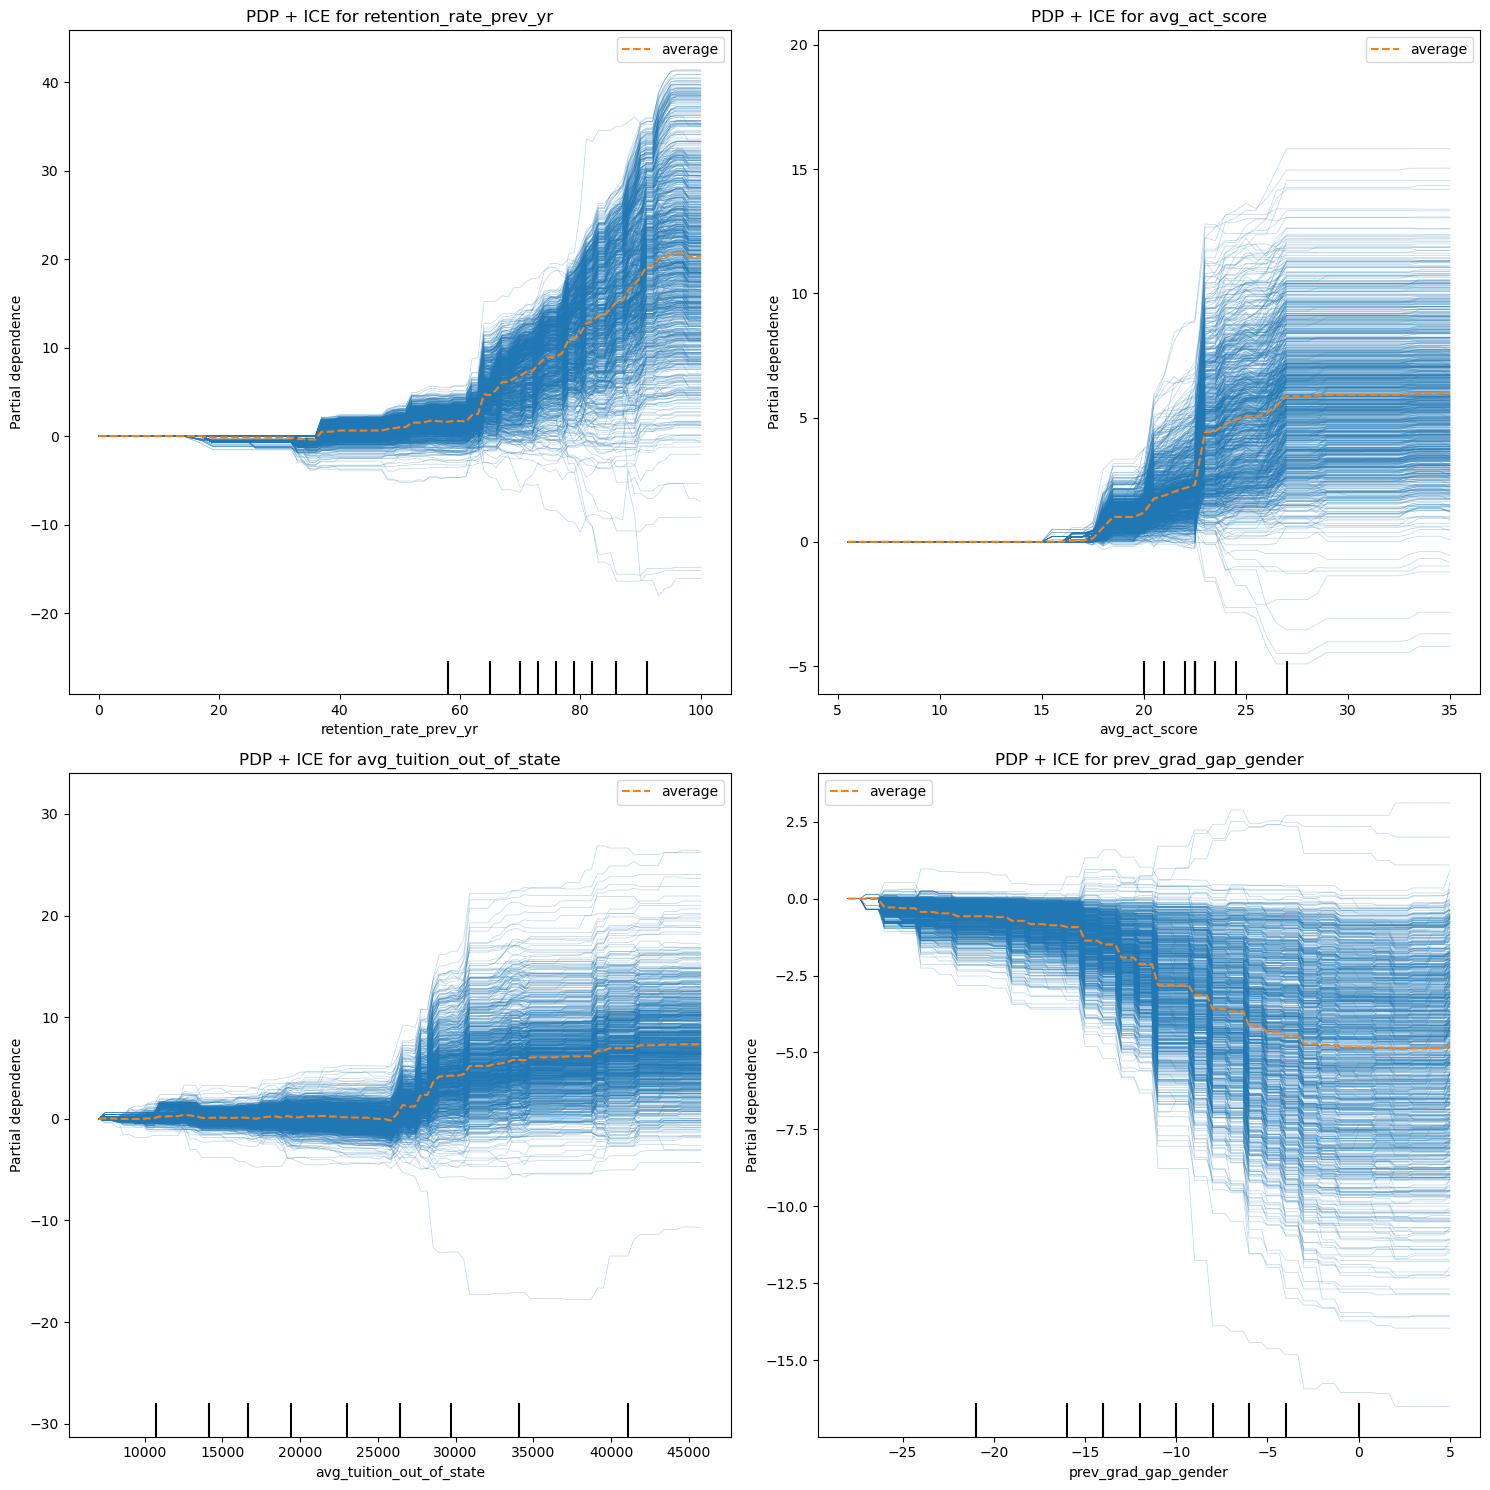

In [31]:

_, ax = plt.subplots(2, 2, figsize=(15, 15), sharey=True)
axes = ax.flatten()

# Plot PDPs for key features
features_to_plot = ['retention_rate_prev_yr', 'avg_act_score', 
                    'avg_tuition_out_of_state', 'prev_grad_gap_gender']

for i, feature in enumerate(features_to_plot):
    PartialDependenceDisplay.from_estimator(best_xgb, 
                                            X_pdp_df, 
                                            features=[feature], 
                                            kind='both', 
                                            ax=axes[i], 
                                            #subsample=300, 
                                            centered=True, 
                                            random_state=RANDOM_STATE)
    
    axes[i].set_title(f"PDP + ICE for {feature}", fontsize=12)


plt.tight_layout()
plt.show()


# Permutation Feature Importance (PFI)
Randomly shuffles each feature and measures how much model performance drops. No plot by default, but you can visualize it manually.
Model-agnostic - works even for black-box models like XGBoost or ensembles. This gives you a trusted global ranking of what matters.

In [32]:
# Run permutation importance on validation set
perm = permutation_importance(best_xgb, X_pdp_df, y_data, n_repeats=10, random_state=RANDOM_STATE)

# Create a sorted Series
importances = pd.Series(perm.importances_mean, index=X_pdp_df.columns)
importances = importances.sort_values(ascending=False)


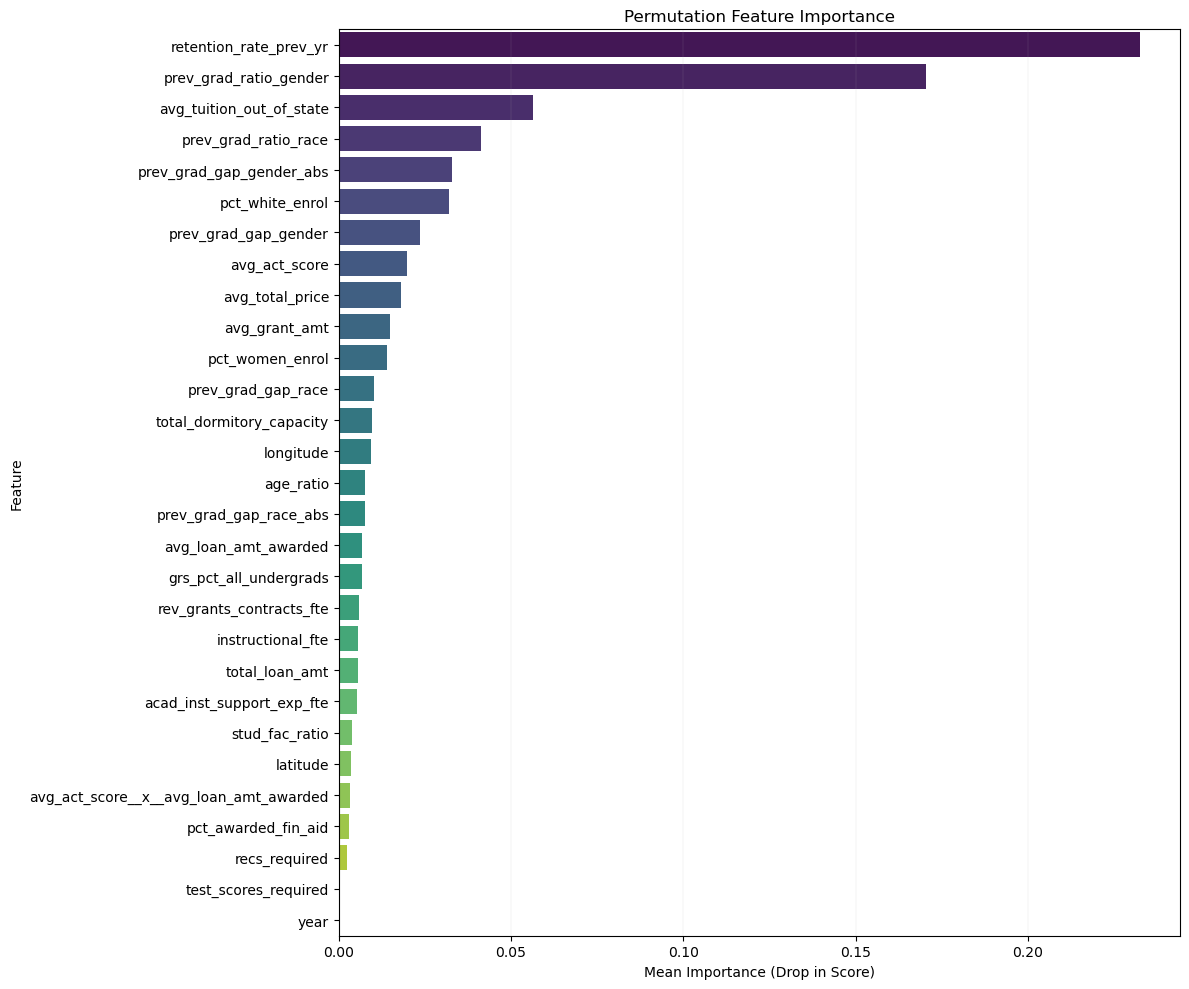

In [33]:

# Plot
plt.figure(figsize=(12,10))
sns.barplot(x=importances, y=importances.index, palette='viridis')
plt.grid(axis='x', linewidth=0.1)
plt.title("Permutation Feature Importance")
plt.xlabel("Mean Importance (Drop in Score)")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig('PI_plot.png', dpi=300, bbox_inches='tight')
plt.show()


# Plots for Paper
Shows how changing a feature affects predictions for individual examples, not just the average like PDP.

In [34]:
def plot_explainability_pair(feature, interaction_feature=None, save_path=None):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # SHAP Dependence Plot (with interaction)
    shap.plots.scatter(shap_values[:, feature], 
                       color=shap_values[:, interaction_feature], ax=axes[0], 
                      show=False
                      )
    axes[0].set_title(f"SHAP Dependence: {feature} vs. {interaction_feature}")

    # PDP + ICE
    #from sklearn.inspection import PartialDependenceDisplay
    PartialDependenceDisplay.from_estimator(best_xgb, X_pdp_df, [feature], ax=axes[1], 
                                            kind='both', centered=True, random_state=RANDOM_STATE)
    axes[1].set_title(f"PDP + ICE: {feature}")

    plt.tight_layout()
    
    # Save if save_path is given
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    plt.show()


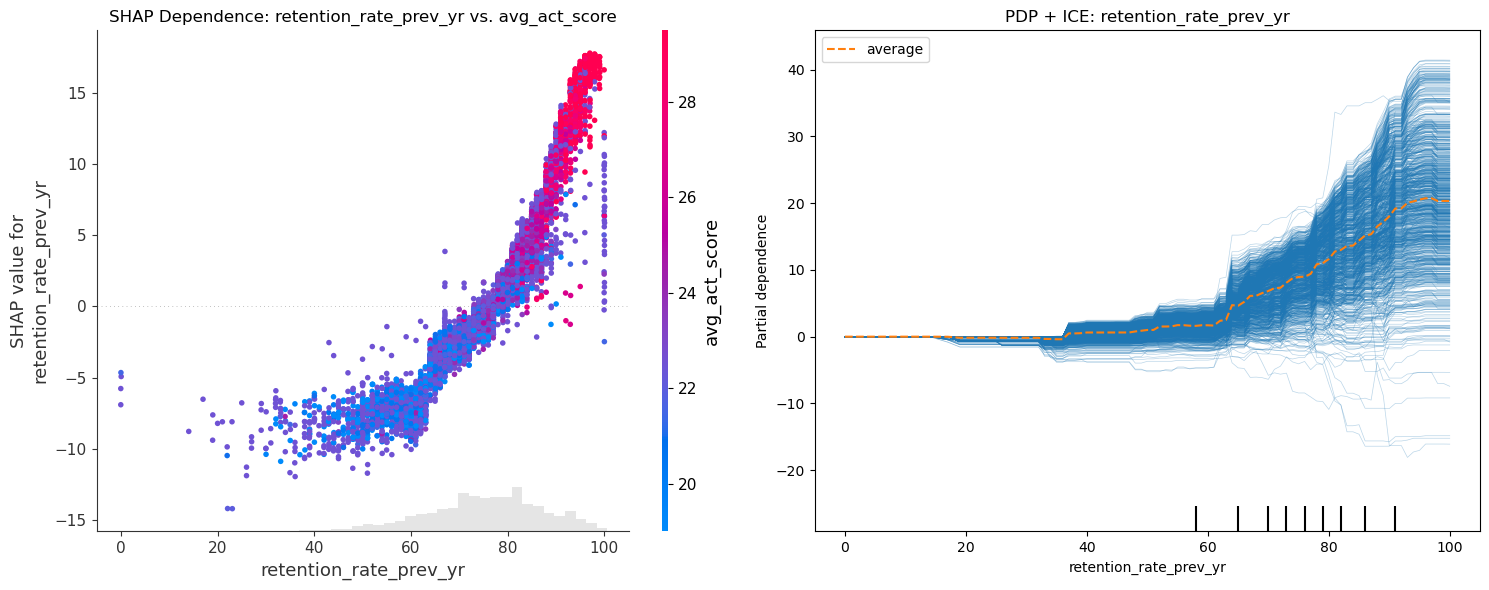

In [35]:
plot_explainability_pair('retention_rate_prev_yr', 'avg_act_score',
                         'C:\\Users\\Lenovo\\Desktop\\DATA SCIENCE\\PAPER\\education paper\\Plots\\retention_act_explainability.png')

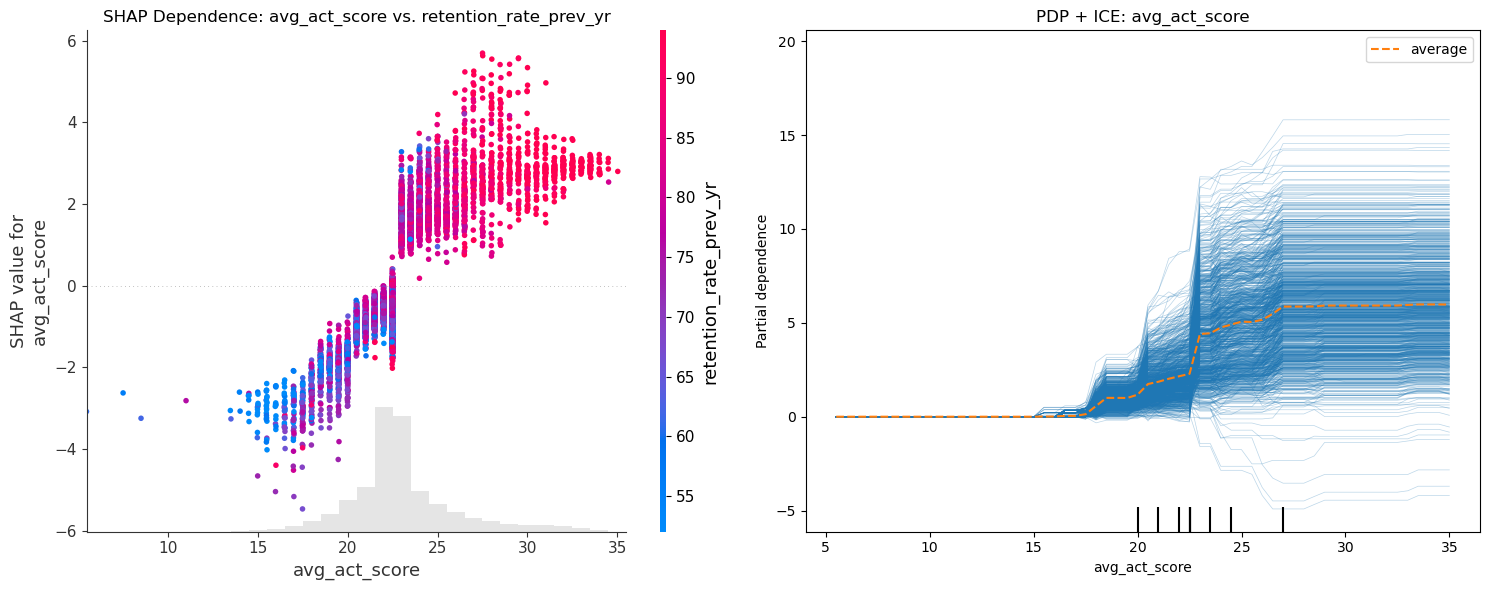

In [36]:
plot_explainability_pair('avg_act_score', 'retention_rate_prev_yr', 
                         'C:\\Users\\Lenovo\\Desktop\\DATA SCIENCE\\PAPER\\education paper\\Plots\\act_retention_explainability.png')

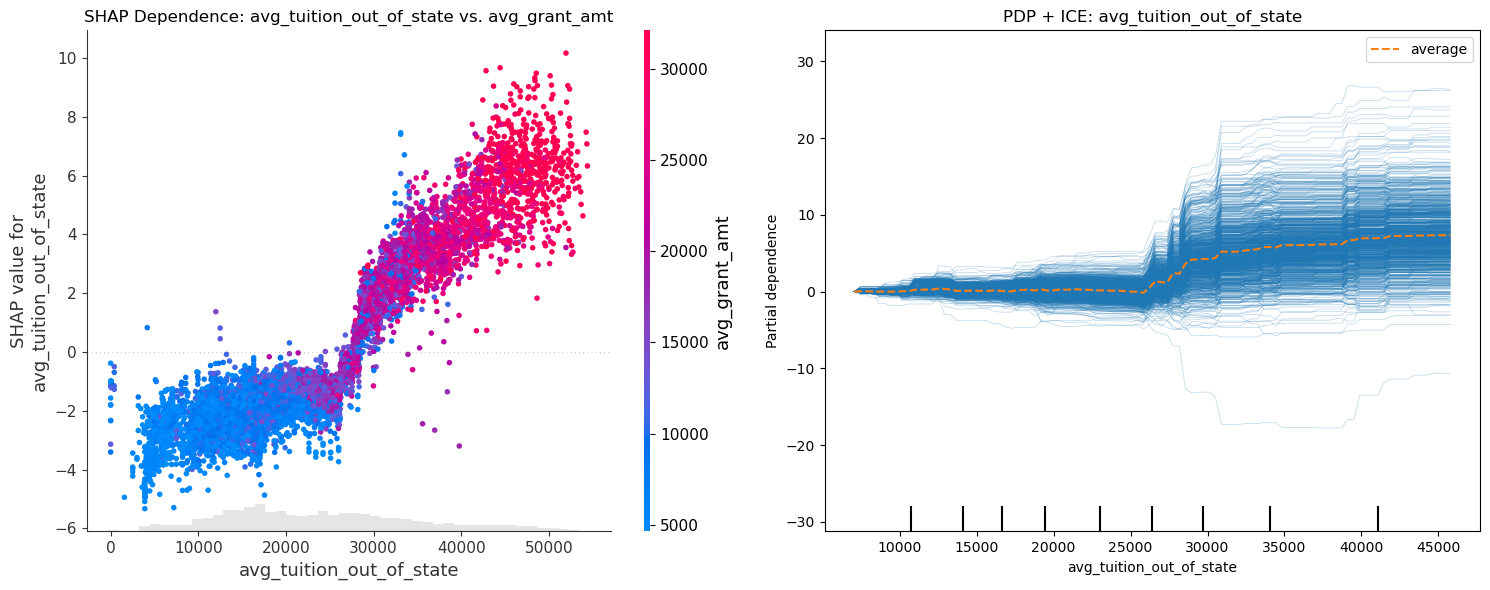

In [37]:
plot_explainability_pair('avg_tuition_out_of_state', 'avg_grant_amt', 
                         'C:\\Users\\Lenovo\\Desktop\\DATA SCIENCE\\PAPER\\education paper\\Plots\\tuition_grant_explainability.png')

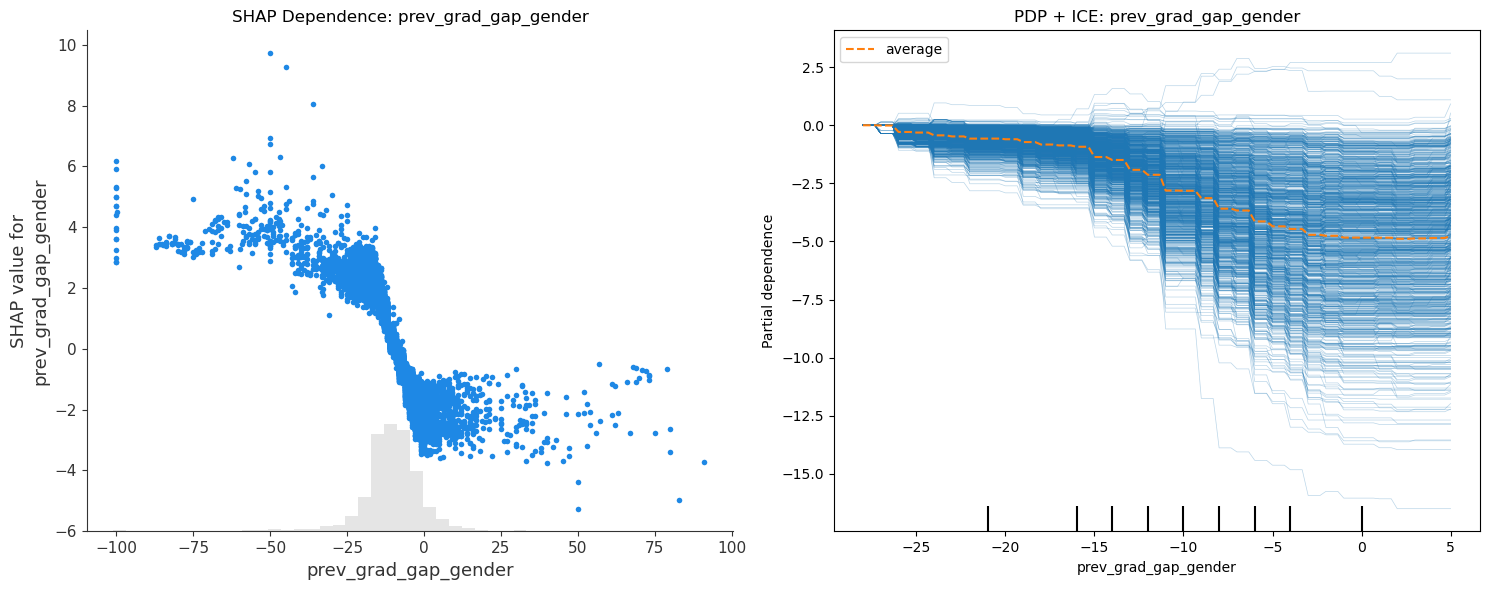

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
# SHAP Dependence Plot (with interaction)
shap.plots.scatter(shap_values[:, 'prev_grad_gap_gender'], 
                   ax=axes[0], 
                  show=False
                  )
axes[0].set_title(f"SHAP Dependence: prev_grad_gap_gender")

# PDP + ICE
#from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(best_xgb, X_pdp_df, ['prev_grad_gap_gender'], ax=axes[1], 
                                        kind='both', centered=True, random_state=RANDOM_STATE)
axes[1].set_title(f"PDP + ICE: prev_grad_gap_gender")

plt.tight_layout()
plt.savefig('C:\\Users\\Lenovo\\Desktop\\DATA SCIENCE\\PAPER\\education paper\\Plots\\gender gap difference.png', 
            dpi=300, bbox_inches='tight')

plt.show()

